# Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Chargement des données

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('../x_train.csv', index_col='ID')
y_train = pd.read_csv('../y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('../x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [3]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]

# Exploration des secteurs

Nombre de points par secteur :

In [4]:
nb_sec = len(train.SECTOR.unique())

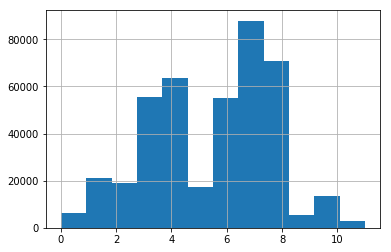

In [5]:
train.SECTOR.hist(bins=nb_sec)

In [6]:
train.groupby(by='SECTOR').count()['DATE']

SECTOR
0      6304
1     21264
2     18967
3     55473
4     63519
5     17295
6     55123
7     87903
8     70843
9      5555
10    13295
11     3054
Name: DATE, dtype: int64

# Cross validation

In [7]:
# Paramètres :
N = 4 #nombre de folds
nb_feat = 20 #nb de jours pris en compte
nb_shifts = 5 #nombre de features supplémentaires

# Séparation en N folds :
scores=[]
kf = KFold(n_splits=N,shuffle=True,random_state=1)
for fold, (ind_train, ind_test) in enumerate(kf.split(train)):
    
    # Nettoyage des données :
    train_cl = train.loc[ind_train]
    test_cl = train.loc[ind_test]
    for sect in range(nb_sec):
        for ret_t,vol_t in zip(ret,vol):
            med_ret = train_cl[ret_t][train_cl['SECTOR']==sect].median()
            med_vol = train_cl[vol_t][train_cl['SECTOR']==sect].median()
            train_cl[ret_t] = train_cl[ret_t].fillna(med_ret)
            train_cl[vol_t] = train_cl[vol_t].fillna(med_vol)
            test_cl[ret_t] = test_cl[ret_t].fillna(med_ret)
            test_cl[vol_t] = test_cl[vol_t].fillna(med_vol)

    # Mise à l'échelle :
    scaler = StandardScaler()
    train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
    test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])

    # Sélection des features :
    features_base = ret[-nb_feat:]+vol[-nb_feat:]
    target = 'RET'
    new_features = []
    shifts = range(1,nb_shifts+1)
    statistics = ['median']
    gb_features = ['INDUSTRY_GROUP', 'DATE']
    target_feature = 'RET'
    tmp_name = '_'.join(gb_features)
    for shift in shifts:
        for stat in statistics:
            name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
            feat = f'{target_feature}_{shift}'
            new_features.append(name)
            for data in [train_cl,test_cl]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)
    features = features_base + new_features
    
    # Entraînement des modèles :
    models = []
    for sect in range(nb_sec):
        x_train_cl = train_cl[features][train_cl['SECTOR']==sect]
        y_train_cl = train_cl[target][train_cl['SECTOR']==sect]
        rf_params = {
        'n_estimators': 500,
        'max_depth': 2**3,
        'random_state': 0,
        'n_jobs': -1
        }
        model = RandomForestClassifier(**rf_params)
        model.fit(x_train_cl, y_train_cl)
        models.append(model)
        print(f"Fold {fold+1} - Modèle {sect} entraîné")

    # Prédiction :
    y_pred = pd.Series()
    index0 = test_cl.index
    for sect in range(nb_sec):
        x_test = test_cl.loc[test_cl['SECTOR']==sect].loc[:,features]
        index = x_test.index
        y_test = test_cl.loc[test_cl['SECTOR']==sect].loc[:,target]
        model = models[sect]
        y_pred = pd.concat([y_pred,pd.Series(model.predict(x_test),index=x_test.index)])
    y_pred = y_pred[index0]
    score = accuracy_score(test_cl[target], y_pred)
    print(f"Score fold {fold+1} : {score* 100:.2f}")
    scores.append(score)

# Résultats finaux :
mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Modèle 0 entraîné
Fold 1 - Modèle 1 entraîné
Fold 1 - Modèle 2 entraîné
Fold 1 - Modèle 3 entraîné
Fold 1 - Modèle 4 entraîné
Fold 1 - Modèle 5 entraîné
Fold 1 - Modèle 6 entraîné
Fold 1 - Modèle 7 entraîné
Fold 1 - Modèle 8 entraîné
Fold 1 - Modèle 9 entraîné
Fold 1 - Modèle 10 entraîné
Fold 1 - Modèle 11 entraîné
Score fold 1 : 56.14
Fold 2 - Modèle 0 entraîné
Fold 2 - Modèle 1 entraîné
Fold 2 - Modèle 2 entraîné
Fold 2 - Modèle 3 entraîné
Fold 2 - Modèle 4 entraîné
Fold 2 - Modèle 5 entraîné
Fold 2 - Modèle 6 entraîné
Fold 2 - Modèle 7 entraîné
Fold 2 - Modèle 8 entraîné
Fold 2 - Modèle 9 entraîné
Fold 2 - Modèle 10 entraîné
Fold 2 - Modèle 11 entraîné
Score fold 2 : 56.07
Fold 3 - Modèle 0 entraîné
Fold 3 - Modèle 1 entraîné
Fold 3 - Modèle 2 entraîné
Fold 3 - Modèle 3 entraîné
Fold 3 - Modèle 4 entraîné
Fold 3 - Modèle 5 entraîné
Fold 3 - Modèle 6 entraîné
Fold 3 - Modèle 7 entraîné
Fold 3 - Modèle 8 entraîné
Fold 3 - Modèle 9 entraîné
Fold 3 - Modèle 10 entraîné
Fold 3 -

# Submit

In [8]:
# # Paramètres :
# nb_feat = 20 #nb de jours pris en compte
# nb_shifts = 10 #nombre de features supplémentaires

# # Nettoyage des données :
# train_cl = train.copy()
# test_cl = test.copy()
# for sect in range(nb_sec):
#     for ret_t,vol_t in zip(ret,vol):
#         med_ret = train_cl[ret_t][train_cl['SECTOR']==sect].median()
#         med_vol = train_cl[vol_t][train_cl['SECTOR']==sect].median()
#         train_cl[ret_t] = train_cl[ret_t].fillna(med_ret)
#         train_cl[vol_t] = train_cl[vol_t].fillna(med_vol)
#         test_cl[ret_t] = test_cl[ret_t].fillna(med_ret)
#         test_cl[vol_t] = test_cl[vol_t].fillna(med_vol)

# # Mise à l'échelle :
# scaler = StandardScaler()
# train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
# test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])

# # Sélection des features :
# features_base = ret[-nb_feat:]+vol[-nb_feat:]
# target = 'RET'
# new_features = []
# shifts = range(1,nb_shifts+1)
# statistics = ['median']
# gb_features = ['INDUSTRY_GROUP', 'DATE']
# target_feature = 'RET'
# tmp_name = '_'.join(gb_features)
# for shift in shifts:
#     for stat in statistics:
#         name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
#         feat = f'{target_feature}_{shift}'
#         new_features.append(name)
#         for data in [train_cl,test_cl]:
#             data[name] = data.groupby(gb_features)[feat].transform(stat)
# features = features_base + new_features

# # Entraînement des modèles :
# models = []
# for sect in range(nb_sec):
#     x_train_cl = train_cl[features][train_cl['SECTOR']==sect]
#     y_train_cl = train_cl[target][train_cl['SECTOR']==sect]
#     rf_params = {
#     'n_estimators': 500,
#     'max_depth': 2**3,
#     'random_state': 0,
#     'n_jobs': -1
#     }
#     model = RandomForestClassifier(**rf_params)
#     model.fit(x_train_cl, y_train_cl)
#     models.append(model)
#     print(f"Modèle {sect} entraîné")

# # Prédiction :
# y_pred = pd.Series()
# index0 = test_cl.index
# for sect in range(nb_sec):
#     x_test = test_cl.loc[test_cl['SECTOR']==sect].loc[:,features]
#     index = x_test.index
#     model = models[sect]
#     y_pred = pd.concat([y_pred,pd.Series(model.predict(x_test),index=x_test.index)])
# y_pred = y_pred[index0]

In [9]:
y_pred.name = target
y_pred.to_csv('./sub1110F2.csv', index=True, header=True)

Paramètres : nb_feat = 20, nb_shifts = 10

Public score : 50.51%